In [2]:
#Carregando as bibliotecas necessárias para o tratamento dos dados
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy.cli
spacy.cli.download("pt_core_news_sm")
import pt_core_news_sm
spc_pt = pt_core_news_sm.load()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

%matplotlib inline

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# carregando o dataset
data = pd.read_csv(r'csvs\archive\olist_order_reviews_dataset.csv')

In [4]:
#verificando a saída
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [5]:
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [6]:
#Retirando as colunas que não vamos utilizar na análise de NLP
data.drop(['review_creation_date', 'review_answer_timestamp'],
          1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               99224 non-null  object
 1   order_id                99224 non-null  object
 2   review_score            99224 non-null  int64 
 3   review_comment_title    11568 non-null  object
 4   review_comment_message  40977 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
#Verificando valores duplicados (pela coluna review_id)
data[data.duplicated("review_id", keep =  False)].sort_values(by = "review_id")

,review_id,order_id,review_score,review_comment_title,review_comment_message
46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid..."
90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,NaN
63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,NaN
92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,NaN,Produto entregue dentro de embalagem do fornec...
...,...,...,...,...,...
31120,fe5c833752953fed3209646f1f63b53c,4863e15fa53273cc7219c58f5ffda4fb,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ..."
7870,ff2fc9e68f8aabfbe18d710b83aabd30,2da58e0a7dcfa4ce1e00fad9d03ca3b5,2,NaN,NaN
82521,ff2fc9e68f8aabfbe18d710b83aabd30,1078d496cc6ab9a8e6f2be77abf5091b,2,NaN,NaN
73951,ffb8cff872a625632ac983eb1f88843c,c44883fc2529b4aa03ca90e7e09d95b6,3,NaN,NaN


In [8]:
# remove os duplicados para nao influenciar no desempenho do modelo preditivo
data.drop_duplicates("review_id", inplace = True) 

In [9]:
#Como temos colunas com dados semelhantes, vamos unir as colunas 
#titulo do comentário e o comentário. Para não haver problemas,
#vamos preencher os valores nulos com ''
data.fillna('', inplace = True)

In [10]:
# concatenando as duas colunas
data['review'] = data['review_comment_title'] + ' ' + data['review_comment_message']

In [11]:
# removendo entradas sem texto
data = data[data['review'] != ' ']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42389 entries, 3 to 99223
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   order_id                42389 non-null  object
 2   review_score            42389 non-null  int64 
 3   review_comment_title    42389 non-null  object
 4   review_comment_message  42389 non-null  object
 5   review                  42389 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.3+ MB


In [12]:
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok..."


In [13]:
#checando os valores das notas
data['review_score'].value_counts()

5    21672
1     8723
4     6241
3     3615
2     2138
Name: review_score, dtype: int64

In [14]:
#Criando rótulos das notas na coluna 'labels'.
# para notas 1,2: valor 0
# a nota 3 será descartada neste momento, pois há um misto de sentimentos nela
#as notas 4 3 5 recebem o valor 1, significando, valores positivos.

labels = []

for score in data['review_score']:
  if score > 3:
    labels.append(1)
  else:
    labels.append(0)

data['label'] = labels

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42389 entries, 3 to 99223
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               42389 non-null  object
 1   order_id                42389 non-null  object
 2   review_score            42389 non-null  int64 
 3   review_comment_title    42389 non-null  object
 4   review_comment_message  42389 non-null  object
 5   review                  42389 non-null  object
 6   label                   42389 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.6+ MB


In [16]:
filtro = data[data.review_score != 3]

In [17]:
data = filtro

In [18]:
#checando a saída
data


,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",1


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


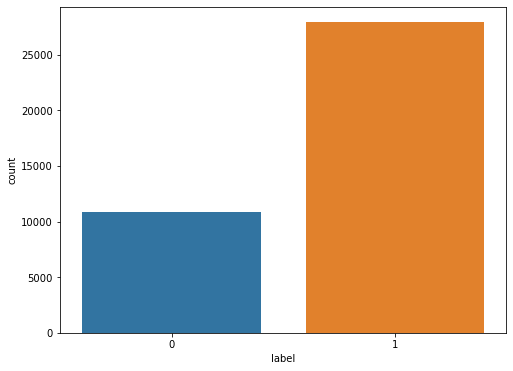

In [19]:
#plotando um gráfico par visualização do label
plt.figure(figsize=(8,6))
sns.countplot(data['label'])
plt.show()

# Analisando o conteúdo dos comentários

In [20]:
#importando as bibliotecas necessárias
import matplotlib.pyplot as plt
from PIL import Image
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import nltk
import numpy as np
import pandas as pd
import wordcloud
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\flash\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# Análise de comentários do setor de móveis de escritório na cidade de Itaquaquecetuba

In [21]:
# puxando outros datasets
sellers = pd.read_csv(r'csvs\archive\olist_sellers_dataset.csv')
items = pd.read_csv(r'csvs\archive\olist_order_items_dataset.csv')
products = pd.read_csv(r'csvs\archive\olist_products_dataset.csv')
orders = pd.read_csv(r'csvs\archive\olist_orders_dataset.csv')

In [22]:
# juntando os data sets
result = sellers.merge(items, on="seller_id", how="left")
result = result.merge(products, on='product_id', how='left')
result = result.merge(orders, on='order_id', how='left')
data_itaqua = data.merge(result, on='order_id', how='left')


In [23]:
# identificando dados duplicados
data_itaqua[data_itaqua.duplicated("review_id", keep =  False)].sort_values(by = "review_id")

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label,seller_id,seller_zip_code_prefix,seller_city,...,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2780,001d005e8f06c039464425cf266248e8,d8711cd641288f4e2e1a84dc3c6ade21,4,,"Inicialmente o pedido veio incompleto, passei ...","Inicialmente o pedido veio incompleto, passei...",1,5075aaa8404020ae6aa8bf4792099b41,37706.0,pocos de caldas,...,16.0,25.0,23.0,2136055ed9bb96ae2c2a47e727f791ae,delivered,2017-07-25 16:39:25,2017-07-25 16:50:19,2017-07-28 20:39:45,2017-07-31 20:32:58,2017-08-09 00:00:00
2781,001d005e8f06c039464425cf266248e8,d8711cd641288f4e2e1a84dc3c6ade21,4,,"Inicialmente o pedido veio incompleto, passei ...","Inicialmente o pedido veio incompleto, passei...",1,5075aaa8404020ae6aa8bf4792099b41,37706.0,pocos de caldas,...,16.0,25.0,23.0,2136055ed9bb96ae2c2a47e727f791ae,delivered,2017-07-25 16:39:25,2017-07-25 16:50:19,2017-07-28 20:39:45,2017-07-31 20:32:58,2017-08-09 00:00:00
2892,00340557e47d90c6c5ba1dc739de566c,f82a2055f59b4ccf07be7a6e9d52debd,5,,Gostei demais. Bem em conta e foi entregue sup...,Gostei demais. Bem em conta e foi entregue su...,1,7d76b645482be4a332374e8223836592,1511.0,sao paulo,...,18.0,6.0,11.0,48970007c61cc12f2624b1212e10419f,delivered,2017-10-05 13:56:51,2017-10-05 14:07:25,2017-10-06 21:03:09,2017-10-07 15:58:34,2017-10-24 00:00:00
2891,00340557e47d90c6c5ba1dc739de566c,f82a2055f59b4ccf07be7a6e9d52debd,5,,Gostei demais. Bem em conta e foi entregue sup...,Gostei demais. Bem em conta e foi entregue su...,1,7d76b645482be4a332374e8223836592,1511.0,sao paulo,...,18.0,6.0,11.0,48970007c61cc12f2624b1212e10419f,delivered,2017-10-05 13:56:51,2017-10-05 14:07:25,2017-10-06 21:03:09,2017-10-07 15:58:34,2017-10-24 00:00:00
41550,00343e1d7afe6b95442fc008abe9763f,b55e03266fc482bd2d25a8116a8be42d,2,,mercadorias meio confusas comprei 2 itens do m...,mercadorias meio confusas comprei 2 itens do ...,0,1025f0e2d44d7041d6cf58b6550e0bfa,3204.0,sao paulo,...,20.0,35.0,20.0,2cbf5763626df1af3fbe147aa470f2a6,delivered,2018-01-03 21:00:58,2018-01-05 02:38:07,2018-01-05 18:15:25,2018-01-12 21:21:53,2018-02-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41108,ffa91419c3521af8c9d224a198f59a27,93f27293d6f1881d4784abaf47d53ffe,5,,Comprei o produto como original e veio um comp...,Comprei o produto como original e veio um com...,1,229c3efbfb0ea2058de4ccdfbc3d784a,30190.0,belo horizonte,...,16.0,5.0,11.0,af20e4d9bc9c5a59eca2afb75030eb4a,delivered,2017-06-27 11:20:17,2017-06-27 12:04:01,2017-06-27 15:52:30,2017-07-10 20:42:06,2017-07-19 00:00:00
41107,ffa91419c3521af8c9d224a198f59a27,93f27293d6f1881d4784abaf47d53ffe,5,,Comprei o produto como original e veio um comp...,Comprei o produto como original e veio um com...,1,229c3efbfb0ea2058de4ccdfbc3d784a,30190.0,belo horizonte,...,16.0,13.0,11.0,af20e4d9bc9c5a59eca2afb75030eb4a,delivered,2017-06-27 11:20:17,2017-06-27 12:04:01,2017-06-27 15:52:30,2017-07-10 20:42:06,2017-07-19 00:00:00
673,ffba674dbbc0250e36889712458d81f3,f3c7f31502a61f206c30c674a4ada401,1,,Vcs tá deixando a desejar comprei produtos com...,Vcs tá deixando a desejar comprei produtos co...,0,8931a84a914b3fe9b1ddaa4d704947ca,8410.0,sao paulo,...,20.0,20.0,20.0,829c1d7ef490598e1c6a463084fd15e2,delivered,2017-05-27 23:35:14,2017-05-28 01:05:14,2017-06-01 13:25:34,2017-06-19 18:58:01,2017-06-09 00:00:00
674,ffba674dbbc0250e36889712458d81f3,f3c7f31502a61f206c30c674a4ada401,1,,Vcs tá deixando a desejar comprei produtos com...,Vcs tá deixando a desejar comprei produtos co...,0,8931a84a914b3fe9b1ddaa4d704947ca,8410.0,sao paulo,...,20.0,20.0,20.0,829c1d7ef490598e1c6a463084fd15e2,delivered,2017-05-27 23:35:14,2017-05-28 01:05:14,2017-06-01 13:25:34,2017-06-19 18:58:01,2017-06-09 00:00:00


In [24]:
# removendo dados duplicados
data_itaqua.drop_duplicates("review_id", inplace = True) 

In [25]:
# filtrando colunas
filtro2 = data_itaqua[['review_id', 'review_score', 'review_comment_title', 'review_comment_message','review', 'seller_id', 'seller_city', 'product_category_name' ]]

In [26]:
data_itaqua = filtro2
data_itaqua

,review_id,review_score,review_comment_title,review_comment_message,review,seller_id,seller_city,product_category_name
0,e64fb393e7b32834bb789ff8bb30750e,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,a1043bafd471dff536d0c462352beb48,ilicinea,ferramentas_jardim
1,f7c4243c7fe1938f181bec41a392bdeb,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,989becdce12ebc39863c2bceab6f3ca1,curitiba,esporte_lazer
2,8670d52e15e00043ae7de4c01cc2fe06,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,05ff92fedb5be47920fea08e501238b9,santo angelo,eletroportateis
3,4b49719c8a200003f700d3d986ea1a19,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.\r\n",db4350fd57ae30082dec7acbaacc17f9,sao paulo,beleza_saude
4,3948b09f7c818e2d86c9a546758b2335,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",974cf2cb8f4b7add98709c30df02fe10,araraquara,informatica_acessorios
...,...,...,...,...,...,...,...,...
45304,5085bc489aa6b58a29c4f922d59ff826,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0b35c634521043bf4b47e21547b99ab5,teixeira soares,construcao_ferramentas_construcao
45305,98fffa80dc9acbde7388bef1600f3b15,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,6560211a19b47992c3666cc44a7e94c0,sao paulo,relogios_presentes
45306,df5fae90e85354241d5d64a8955b2b09,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,432c37c9dfba871172ec162e20118b8c,brasilia,esporte_lazer
45307,b3de70c89b1510c4cd3d0649fd302472,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",17ca9b9e9b9ef8fdb529001b49ebb50f,betim,papelaria


<h3> Preparação do arquivo para criação de nuvem dos comentários para as vendas de móveis e escritório na cidade de Itaquaquecetuba </h3>

In [27]:
# aplicando filtro pra Itaquaquecetuba
filtro3 = (data_itaqua['product_category_name'] == 'moveis_escritorio') & (data_itaqua['seller_city'] == 'itaquaquecetuba')
data_itaqua_moveis = data_itaqua[filtro3]

In [28]:
#trabalhando com o Stopwords
stopwords_pt = stopwords.words("portuguese")
stopwords_pt

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [29]:
#Como os advérbios 'não' e 'nem' são importantes neste caso do e-commerce,
#vamos retirar essas palavras da lista de stopwords:
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [30]:
#Definindo as funções para tratamento do texto
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

# Criando a lista de comentários das reviews
reviews1 = list(data_itaqua_moveis['review'].values)

# Aplicando regex
reviews_breakline1 = re_breakline(reviews1)

# atualizando o dataset
data_itaqua_moveis['review'] = reviews_breakline1
data_itaqua_moveis


<ipython-input-30-fb0c5b7eadac>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_breakline1


,review_id,review_score,review_comment_title,review_comment_message,review,seller_id,seller_city,product_category_name
170,5d6f9cddc8335878d8bf20c3bd4602e8,5,mega recomendo,Recebi meu produto corretamente e dentro do pr...,mega recomendo Recebi meu produto corretamente...,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
277,edd86e0af4dc62b340c60d846643cbf9,5,PRODUTO OK,"prazo foi estendido,porém entregue no prazo di...","PRODUTO OK prazo foi estendido,porém entregue ...",7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
291,e47020cf52099bce9dc57524ea41218b,4,,Indico a loja compro sempre na lannister .,Indico a loja compro sempre na lannister .,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
320,8f16e30ff188fe57a427fee7afb60c90,1,,O tampo da mesa chegou todo amassado e batido.,O tampo da mesa chegou todo amassado e batido.,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
338,24203dee295cf23bd24b7ace9bca261f,1,,"Produto mais que passou do prazo de entregar, ...","Produto mais que passou do prazo de entregar,...",7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
...,...,...,...,...,...,...,...,...
44669,521667297522866412a13bc230dd3c3b,5,,O produto foi entregue com bastante antecedênc...,O produto foi entregue com bastante antecedên...,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
44910,1e2bf06df77bdf3de0bf799f16c0f84d,5,,Prazo de entrega cumprido!,Prazo de entrega cumprido!,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
45047,123381026f13c723cb967b14b1bc673a,5,,"Adorei a cadeira, bonita, confortável e fácil ...","Adorei a cadeira, bonita, confortável e fácil...",7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
45147,5d4beea8e2c71baee7f55c7ae3ae3313,1,Insatisfeita,"A cadeira veio com defeito de fabrica, uma sol...",Insatisfeita A cadeira veio com defeito de fab...,5058e8c1e82653974541e83690655b4a,itaquaquecetuba,moveis_escritorio


In [31]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

#  atualizando o dataset
reviews_hiperlinks1 = re_hiperlinks(reviews_breakline1)
data_itaqua_moveis['review'] = reviews_hiperlinks1

<ipython-input-31-002c489e5912>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_hiperlinks1


In [32]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]
# Atualizando o dataset
reviews_dates1 = re_dates(reviews_hiperlinks1)
data_itaqua_moveis['review'] = reviews_dates1


<ipython-input-32-66dfbdd72ef7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_dates1


In [33]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]
# Aplicando RegEx
reviews_money1 = re_money(reviews_dates1)
data_itaqua_moveis['review'] = reviews_money1


<ipython-input-33-d55e952dfb66>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_money1


In [34]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]
# Atualizando o dataset
reviews_numbers1 = re_numbers(reviews_money1)
data_itaqua_moveis['review'] = reviews_numbers1


<ipython-input-34-85c0571c2fa3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_numbers1


In [35]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # AppAplicando regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]
#Atualizando o dataset
reviews_negation1 = re_negation(reviews_numbers1)
data_itaqua_moveis['review'] = reviews_negation1


<ipython-input-35-6774032de8e7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_negation1


In [36]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    return [re.sub('\W', ' ', r) for r in text_list]

# Atualizando o dataset
reviews_special_chars1 = re_special_chars(reviews_negation1)
data_itaqua_moveis['review'] = reviews_special_chars1

<ipython-input-36-5a7df26c772c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_special_chars1


In [37]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Apicando regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

# Atualizando o dataset
reviews_whitespaces1 = re_whitespaces(reviews_special_chars1)
data_itaqua_moveis['review'] = reviews_whitespaces1


<ipython-input-37-5ff182e85054>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_whitespaces1


In [38]:
# Função para remover o stopwords e transfomar em caixa baixa

def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

# Aplicando e atualizando o dataset
reviews_stopwords1 = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces1]
data_itaqua_moveis['review'] = reviews_stopwords1


<ipython-input-38-3ae9fdb353af>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['review'] = reviews_stopwords1


In [40]:
#Separando palavras
pal_positiva1 = data_itaqua_moveis[data_itaqua_moveis['review_score'] >3]
pal_negativa1 = data_itaqua_moveis[data_itaqua_moveis['review_score'] <3]


,review_id,review_score,review_comment_title,review_comment_message,review,seller_id,seller_city,product_category_name
320,8f16e30ff188fe57a427fee7afb60c90,1,,O tampo da mesa chegou todo amassado e batido.,tampo mesa chegou todo amassado batido,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
338,24203dee295cf23bd24b7ace9bca261f,1,,"Produto mais que passou do prazo de entregar, ...",produto passou prazo entregar tento resolver p...,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
368,70d2258489cae12a65d36c8c09fd54c1,1,,Comprei Rosa com Braços Brancos e entregam tod...,comprei rosa braços brancos entregam toda preta,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
1233,9b85b90c837dc4bb8ebc3bc62e2f86ab,1,,Tentei obter uma resposta sobre o atraso de me...,tentei obter resposta sobre atraso pedido dire...,5058e8c1e82653974541e83690655b4a,itaquaquecetuba,moveis_escritorio
1555,2cfe9b52787853c8f008a1132d1619be,2,,Já foi protocolizada junto ao stark pedido de ...,protocolizada junto stark pedido cancelamento ...,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
...,...,...,...,...,...,...,...,...
43616,c8b00b8c7a3d22c6e66417bdc3aac0e8,1,,O produto chegou com uns parte quebrada,produto chegou uns parte quebrada,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
44064,3df7ea1385e999f44ef91f84956d7672,1,,"Só recebi 01 cadeira, ainda falta uma.",recebi numero cadeira ainda falta,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
44434,4a96759784e9f1085af081331a9c3022,1,,Pedi duas cadeiras e foi entregue apenas uma!!!!,pedi duas cadeiras entregue apenas,7c67e1448b00f6e969d365cea6b010ab,itaquaquecetuba,moveis_escritorio
45147,5d4beea8e2c71baee7f55c7ae3ae3313,1,Insatisfeita,"A cadeira veio com defeito de fabrica, uma sol...",insatisfeita cadeira veio defeito fabrica solt...,5058e8c1e82653974541e83690655b4a,itaquaquecetuba,moveis_escritorio


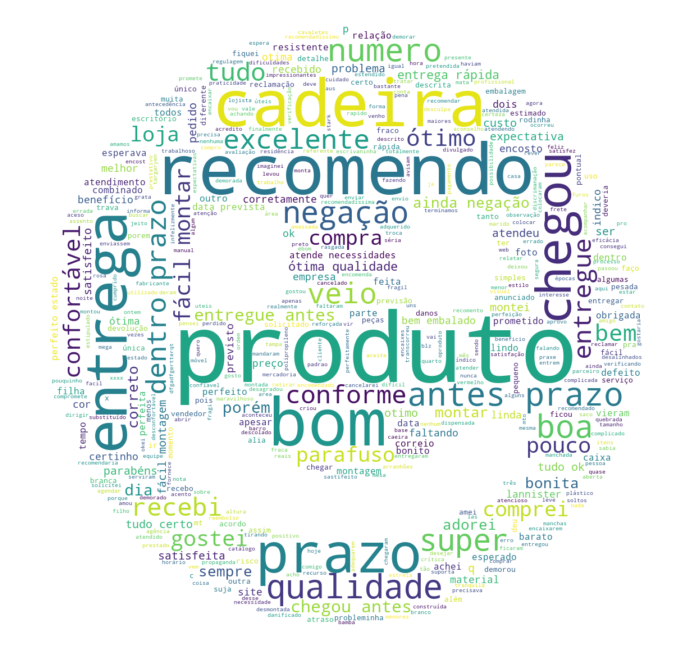

In [39]:
# aplicando nuvem de comentários positivos para Itaquaquecetuba no setor de móveis de escritório
unique_string=(" ").join(pal_positiva1['review'])
mask1 = np.array(Image.open("JPEG/positive.jpg"))

word_cloud3 = WordCloud(width = 2000, height = 1000,background_color='white', mask=mask1, max_words=2000, max_font_size=1000,
                      min_font_size=1).generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(word_cloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

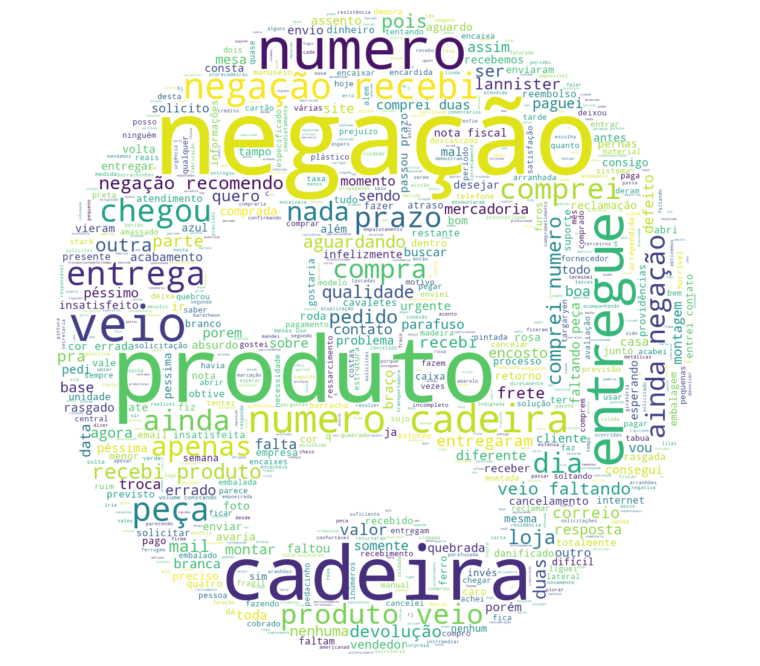

In [40]:
# aplicando nuvem de comentários negativos para Itaquaquecetuba no setor de móveis de escritório
unique_string=(" ").join(pal_negativa1['review'])
mask1 = np.array(Image.open("JPEG/negative.jpg"))

word_cloud4 = WordCloud(width = 2000, height = 1000,background_color='white', mask=mask1, max_words=2000, max_font_size=1000,
                      min_font_size=1).generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(word_cloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
#Criando rótulos das notas na coluna 'labels'.
# para notas 1,2: valor 0
# a nota 3 será descartada neste momento, pois há um misto de sentimentos nela
#as notas 4 e 5 recebem o valor 1, significando, valores positivos.

labels = []

for score in data_itaqua_moveis['review_score']:
  if score > 3:
    labels.append(1)
  else:
    labels.append(0)

data_itaqua_moveis['label'] = labels

<ipython-input-41-d9cf0f6d253a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_itaqua_moveis['label'] = labels


In [42]:
# salvando o dataset processado
data_itaqua_moveis.to_csv('moveis_itaquaquecetuba.csv', index= False, columns= ['review_id', 'review', 'label'])


# Tratando o conteúdo léxico

In [43]:
#trabalhando com o Stopwords
stopwords_pt = stopwords.words("portuguese")
stopwords_pt

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [44]:
#Como os advérbios 'não' e 'nem' são importantes neste caso do e-commerce,
#vamos retirar essas palavras da lista de stopwords:
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [45]:
#Definindo as funções para tratamento do texto
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

# Criando a lista de comentários das reviews
reviews = list(data['review'].values)

# Aplicando regex
reviews_breakline = re_breakline(reviews)

# atualizando o dataset
data['review'] = reviews_breakline
data


,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.",1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",1


In [46]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

#  atualizando o dataset
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
data['review'] = reviews_hiperlinks
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.",1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",1


In [47]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]
# Atualizando o dataset
reviews_dates = re_dates(reviews_hiperlinks)
data['review'] = reviews_dates
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.",1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",1


In [48]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]
# Aplicando RegEx
reviews_money = re_money(reviews_dates)
data['review'] = reviews_money
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.",1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",1


In [49]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]
# Atualizando o dataset
reviews_numbers = re_numbers(reviews_money)
data['review'] = reviews_numbers
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.",1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",1


In [50]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # AppAplicando regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]
#Atualizando o dataset
reviews_negation = re_negation(reviews_numbers)
data['review'] = reviews_negation
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado.,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente. no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n","Mas um pouco ,travando...pelo valor ta Boa.",1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...","Super recomendo Vendedor confiável, produto ok...",1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo. O produto chegou em...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...","Excelente mochila, entrega super rápida. Supe...",1


In [51]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Aplicando regex
    return [re.sub('\W', ' ', r) for r in text_list]

# Atualizando o dataset
reviews_special_chars = re_special_chars(reviews_negation)
data['review'] = reviews_special_chars
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente no site a marca ...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",Mas um pouco travando pelo valor ta Boa,1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",Super recomendo Vendedor confiável produto ok...,1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo O produto chegou em...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",Excelente mochila entrega super rápida Supe...,1


In [52]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Apicando regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

# Atualizando o dataset
reviews_whitespaces = re_whitespaces(reviews_special_chars)
data['review'] = reviews_whitespaces
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,Recebi bem antes do prazo estipulado,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,Parabéns lojas lannister adorei comprar pela ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente no site a marca d...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",Mas um pouco travando pelo valor ta Boa,1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",Super recomendo Vendedor confiável produto ok ...,1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,Tive um problema na entrega em que o correio ...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,para este produto recebi de acordo com a comp...,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,Entregou dentro do prazo O produto chegou em ...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",Excelente mochila entrega super rápida Super ...,1


In [53]:
# Função para remover o stopwords e transfomar em caixa baixa

def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

# Aplicando e atualizando o dataset
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
data['review'] = reviews_stopwords
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipulado,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recomendo aparelho eficiente site marca aparel...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travando valor ta boa,1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",super recomendo vendedor confiável produto ok ...,1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,problema entrega correio colocou site entregue...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,produto recebi acordo compra realizada,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,entregou dentro prazo produto chegou condições...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",excelente mochila entrega super rápida super r...,1


In [54]:
#Separando palavras
pal_positiva = data[data['review_score'] >3]
pal_positiva
pal_negativa = data[data['review_score'] <3]
pal_negativa

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
16,9314d6f9799f5bfba510cc7bcd468c01,0dacf04c5ad59fd5a0cc1faa07c34e39,2,,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",gostaria saber sempre recebi compra agora decp...,0
19,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,negação chegou produto péssimo,0
29,2c5e27fc178bde7ac173c9c62c31b070,0ce9a24111d850192a933fcaab6fbad3,1,,Não gostei ! Comprei gato por lebre,negação gostei comprei gato lebre,0
32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,,Sempre compro pela Internet e a entrega ocorre...,sempre compro internet entrega ocorre antes pr...,0
39,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,,Nada de chegar o meu pedido.,nada chegar pedido,0
...,...,...,...,...,...,...,...
99155,2fc8295a24978092328d3a329d22940e,e809c167a9cfd31aee1293abe8995065,1,,Eu recebi o seguinte email e preciso saber com...,recebi seguinte email preciso saber recuperar ...,0
99169,3450ec3bbabeb09a08b00fc72da87a30,c46f950813dd2dd9bab4188dceb83175,1,,Boa tarde. \r\nNão recebo todos os produtos fa...,boa tarde negação recebo todos produtos falta ...,0
99200,2ee221b28e5b6fceffac59487ed39348,f2d12dd37eaef72ed7b1186b2edefbcd,2,Foto enganosa,Foto muito diferente principalmente a graninha...,foto enganosa foto diferente principalmente gr...,0
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,problema entrega correio colocou site entregue...,0


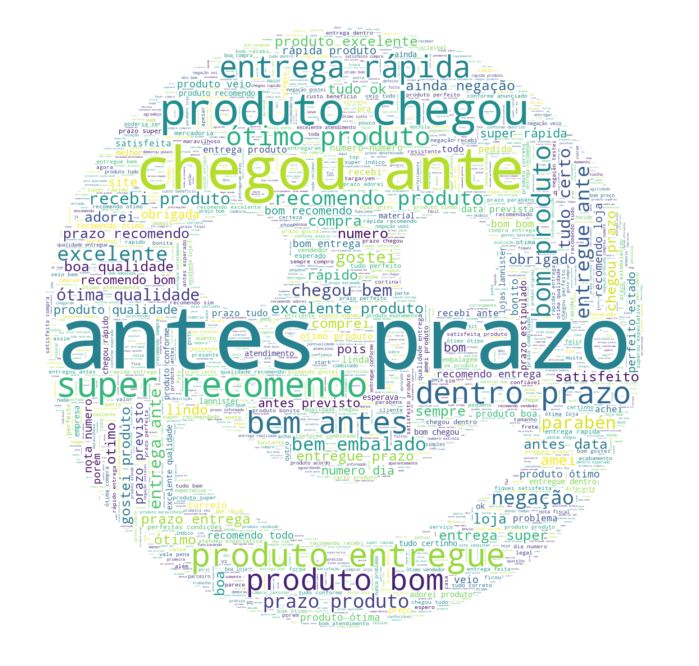

In [55]:
# Geração de nuvem de palavras positivas de vendas em geral
unique_string=(" ").join(pal_positiva['review'])
mask1 = np.array(Image.open("JPEG\positive.jpg"))

word_cloud = WordCloud(width = 2000, height = 1000,background_color='white', mask=mask1, max_words=2000, max_font_size=1000,
                      min_font_size=1).generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

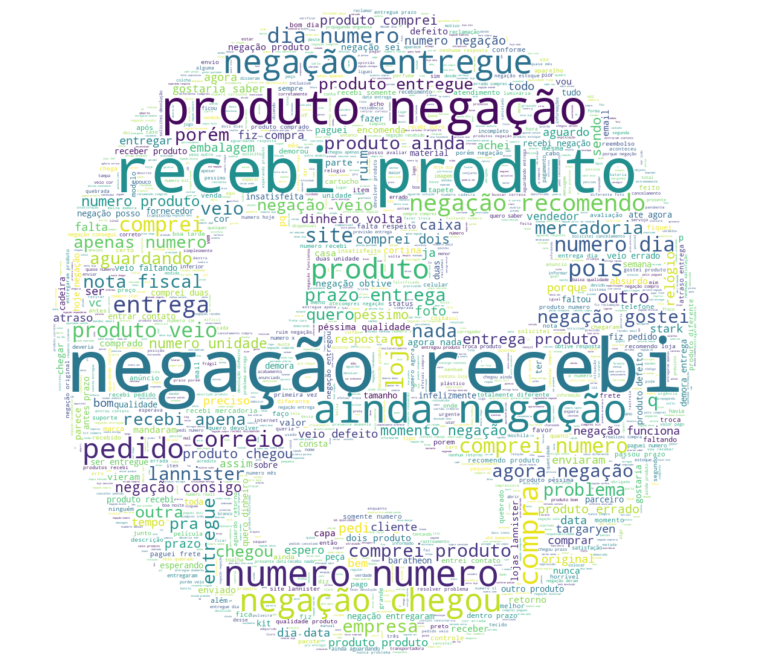

In [56]:
# Geração de nuvem de palavras negativas de vendas em geral

unique_string=(" ").join(pal_negativa['review'])
mask2 = np.array(Image.open("JPEG/negative.jpg"))

word_cloud2 = WordCloud(width = 2000, height = 1000,background_color='white', mask=mask2, max_words=2000, max_font_size=1000).generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [60]:
# Função para stemmer
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

# Aplicando o Stemmer
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
data['review'] = reviews_stemmer
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review,label
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,receb bem ant praz estipul,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,parabém loj lannist ador compr internet segur ...,1
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,recom aparelh efici sit marc aparelh impress n...,1
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouc trav val ta boa,1
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",sup recom vend confi produt ok entreg ant praz,1
...,...,...,...,...,...,...,...
99203,5085bc489aa6b58a29c4f922d59ff826,18ed848509774f56cc8c1c0a1903ad7f,2,,Tive um problema na entrega em que o correio c...,problem entreg correi coloc sit entreg dia num...,0
99205,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,,para este produto recebi de acordo com a compr...,produt receb acord compr realiz,1
99208,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,,Entregou dentro do prazo. O produto chegou em ...,entreg dentr praz produt cheg cond perfeit sat...,1
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",excel mochil entreg sup rápid sup recom loj,1


In [79]:
#verificando valores nulos gerados
data[data['review'] == '']

,review_id,review_score,review_comment_title,review_comment_message,review,label
297,2b4a570df87cd63b232272dd9dcac0cf,5,,A,,1
939,8f965d010b3119d9962e091de3425fb9,4,,*******************,,1
2383,a359af00b3fc204a898ad979ebac38ca,1,,A,,0
3337,64a897235b857e3e09aa49eee59d0b55,5,,. .,,1
3359,42efe873e1d493d3a3a0e4f9b8ed7bee,4,,**,,1
...,...,...,...,...,...,...
93970,480bc69dac211c3ae1a44533394b7d5c,4,,...,,1
94202,86cb15d4a00e8a6ff94f8a30af32d99b,5,,.,,1
94778,014f70270fa59804f14eb3df2ca690d2,5,,........................,,1
96770,47850e2adbd18f61f2af4af9b7656198,5,,👍🏻👌🏻👏🏻,,1


In [61]:
data = data[data['review'] != '']

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38637 entries, 3 to 99223
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               38637 non-null  object
 1   order_id                38637 non-null  object
 2   review_score            38637 non-null  int64 
 3   review_comment_title    38637 non-null  object
 4   review_comment_message  38637 non-null  object
 5   review                  38637 non-null  object
 6   label                   38637 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.4+ MB


In [63]:
# salvando o dataset processado
data.to_csv('olist_preprocessado.csv', index= False, columns= ['review_id', 'review', 'label'])

In [64]:
filtro1 = data[['review_id', 'review', 'label']]

In [65]:
filtro1.to_parquet('olist_preprocessado.parquet', index= False)

In [85]:
#importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38637 entries, 3 to 99223
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_id               38637 non-null  object
 1   order_id                38637 non-null  object
 2   review_score            38637 non-null  int64 
 3   review_comment_title    38637 non-null  object
 4   review_comment_message  38637 non-null  object
 5   review                  38637 non-null  object
 6   label                   38637 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.4+ MB


In [87]:
#Usando trigrams(comentário)
co = CountVectorizer(ngram_range=(3,3))
counts = co.fit_transform(data['review'])
important_trigrams = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(50)
important_trigrams

,0
entreg ant praz,1226
cheg ant praz,1173
neg receb produt,1152
bem ant praz,692
aind neg receb,511
produt cheg ant,463
cheg bem ant,429
produt entreg ant,424
entreg dentr praz,388
produt neg entreg,365


In [88]:
#Criando a maquina preditiva  a partir do comentário
co_counts = CountVectorizer(ngram_range=(1,4))

co_data = co_counts.fit_transform(data['review'])
co_data

<38637x395227 sparse matrix of type '<class 'numpy.int64'>'
	with 909384 stored elements in Compressed Sparse Row format>

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 


from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold


X = co_data
y = data['label']

lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']
nome_das_medidas = ['acurácia', 'sensibilidade', 'precisão', 'eficiência', 'f1-score']

lista_de_modelos = [LogisticRegression(),
                        DecisionTreeClassifier(max_depth = 3),
                        DecisionTreeClassifier(max_depth = 5),
                        DecisionTreeClassifier(max_depth = 7),
                        KNeighborsClassifier(n_neighbors = 5),
                        KNeighborsClassifier(n_neighbors = 15),
                        KNeighborsClassifier(n_neighbors = 25),
                        BaggingClassifier(),
                        RandomForestClassifier(n_estimators=50, max_depth = 5),
                        RandomForestClassifier(n_estimators=50, max_depth = 7),
                        RandomForestClassifier(n_estimators=100, max_depth = 5),
                        RandomForestClassifier(n_estimators=100, max_depth = 7)]

nome_dos_modelos = ['Regressão Logística',
                        'Árvore (prof = 3)',
                        'Árvore (prof = 5)',
                        'Árvore (prof = 7)',
                        '5-NN',
                        '15-NN',
                        '25-NN',
                        'Bagging',
                        'Random Forest (arvs = 50, prof = 5)',
                        'Random Forest (arvs = 50, prof = 7)',
                        'Random Forest (arvs = 100, prof = 5)', 
                        'Random Forest (arvs = 100, prof = 7)']

resultados0 = {}

validacao = StratifiedKFold(n_splits = 10)


for i in range(len(lista_de_modelos)):
    print('Rodando modelo: ' + nome_dos_modelos[i])
    accs_vc = cross_validate(lista_de_modelos[i], X, y, cv = validacao, scoring = lista_de_medidas)

    acc = accs_vc['test_accuracy'].mean()
    sen = accs_vc['test_recall'].mean()
    vpp = accs_vc['test_precision'].mean()
    bac = accs_vc['test_balanced_accuracy'].mean()
    f1s = accs_vc['test_f1'].mean()

    resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, bac, f1s]
    
resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T

Rodando modelo: Regressão Logística


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Rodando modelo: Árvore (prof = 3)
Rodando modelo: Árvore (prof = 5)


# ngram Geral

In [89]:
transformacao_final = data[['review_score', 'review']]

In [90]:
transformacao_final

,review_score,review
3,5,receb bem ant praz estipul
4,5,parabém loj lannist ador compr internet segur ...
9,4,recom aparelh efici sit marc aparelh impress n...
12,4,pouc trav val ta boa
15,5,sup recom vend confi produt ok entreg ant praz
...,...,...
99203,2,problem entreg correi coloc sit entreg dia num...
99205,4,produt receb acord compr realiz
99208,5,entreg dentr praz produt cheg cond perfeit sat...
99221,5,excel mochil entreg sup rápid sup recom loj


In [91]:
# Labelling data
score_map = {
    1: 'negativo',
    2: 'negativo',
    4: 'positivo',
    5: 'positivo'
}
transformacao_final['sentiment_label'] = transformacao_final['review_score'].map(score_map)

# Verifying results
fig, ax = plt.subplots(figsize=(7, 7))
%matplotlib inline

<ipython-input-91-c2255cbaeb3e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformacao_final['sentiment_label'] = transformacao_final['review_score'].map(score_map)


In [92]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [93]:
# Splitting the corpus into positive and negative comments
positive_comments = transformacao_final.query('sentiment_label == "positivo"')['review']
negative_comments = transformacao_final.query('sentiment_label == "negativo"')['review']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Unigrams on Positive Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Unigrams on Negative Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Bigrams on Positive Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Bigrams on Negative Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Trigrams on Positive Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Trigrams on Negative Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

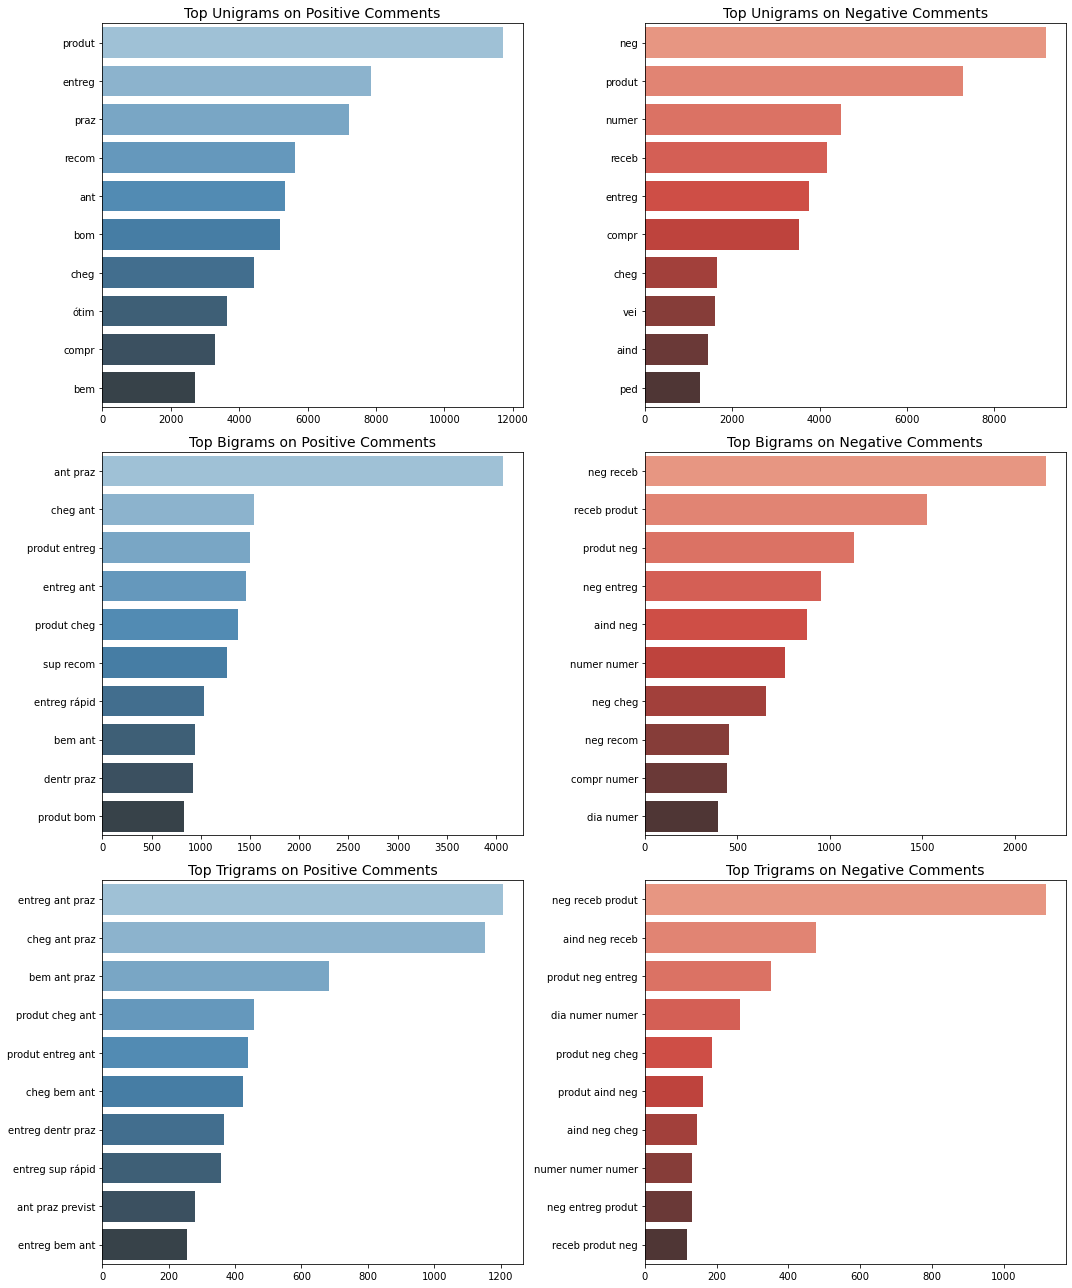

In [94]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    #format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

# ngram - móveis de escritório em Itaquaquecetuba

In [95]:
transformacao_final1 = data_itaqua_moveis[['review_score', 'review']]

In [96]:
transformacao_final1

,review_score,review
170,5,mega recomendo recebi produto corretamente den...
277,5,produto ok prazo estendido porém entregue praz...
291,4,indico loja compro sempre lannister
320,1,tampo mesa chegou todo amassado batido
338,1,produto passou prazo entregar tento resolver p...
...,...,...
44669,5,produto entregue bastante antecedência veio be...
44910,5,prazo entrega cumprido
45047,5,adorei cadeira bonita confortável fácil montar...
45147,1,insatisfeita cadeira veio defeito fabrica solt...


In [97]:
# Labelling data
score_map = {
    1: 'negativo',
    2: 'negativo',
    4: 'positivo',
    5: 'positivo'
}
transformacao_final1['sentiment_label'] = transformacao_final1['review_score'].map(score_map)

# Verifying results
fig, ax = plt.subplots(figsize=(7, 7))
%matplotlib inline

<ipython-input-97-73242d2305a5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformacao_final1['sentiment_label'] = transformacao_final1['review_score'].map(score_map)


In [98]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [99]:
# Splitting the corpus into positive and negative comments
positive_comments = transformacao_final1.query('sentiment_label == "positivo"')['review']
negative_comments = transformacao_final1.query('sentiment_label == "negativo"')['review']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Unigrams on Positive Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Unigrams on Negative Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Bigrams on Positive Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Bigrams on Negative Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Trigrams on Positive Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

<AxesSubplot:xlabel='count', ylabel='ngram'>

Text(0.5, 1.0, 'Top Trigrams on Negative Comments')

Text(0, 0.5, '')

Text(0.5, 0, '')

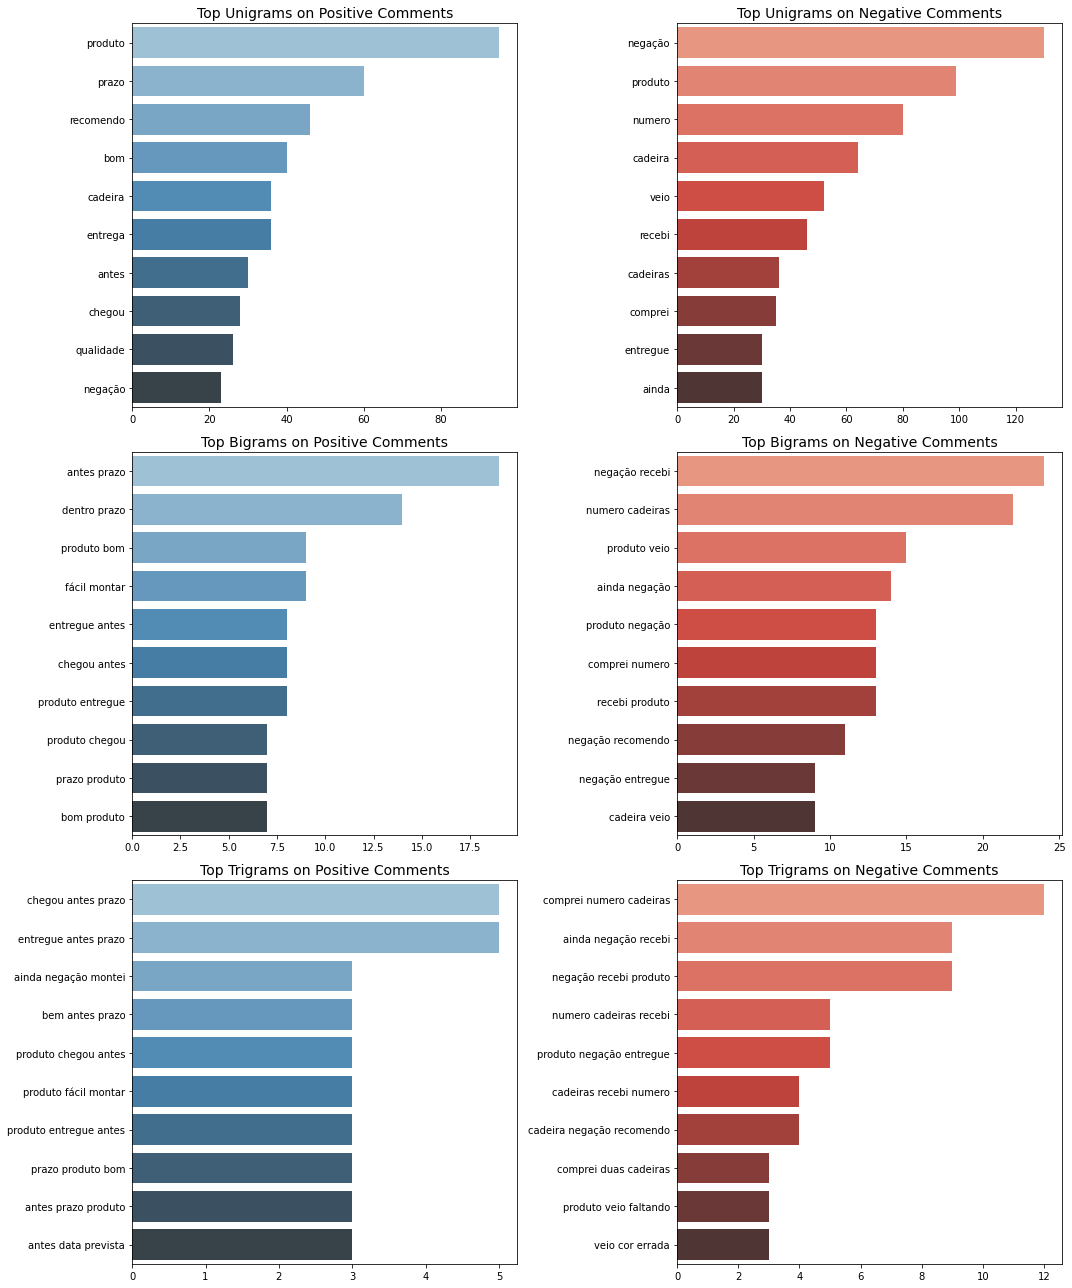

In [101]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    #format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()